# Validation Notebook

Checks that the occupational fit scoring pipeline produces sensible, internally consistent results.

## Tests performed
1. **Formula reproducibility** — recalculate `match_score_final` from components and verify exact match
2. **Match type ordering** — exact title matches should score higher than fuzzy/fallback on average
3. **Category sanity** — `good_match` category should have highest mean scores
4. **Shuffle test** — real user↔SOC pairings should score higher than random permutations
5. **Component correlation** — check inter-component correlations to ensure they capture different signals
6. **Score calibration** — verify the score distribution is spread (not collapsed) and use decile analysis
7. **Position inspection** — spot-check high/low scoring positions for face validity

In [1]:
import pandas as pd
import numpy as np

# Load your final dataset (adjust path)
df = pd.read_csv("../data/final_job_match_dataset.csv")

# Quick required columns check
required = [
    "position_id","user_id","jobtitle_raw","soc_code_final",
    "match_score_tfidf_v2","edu_match_score","exp_match_score","train_match_score",
    "match_score_final"
]
missing = [c for c in required if c not in df.columns]
print("Missing required cols:", missing)

# Basic summary
print(df[["match_score_tfidf_v2","edu_match_score","exp_match_score","train_match_score","match_score_final"]].describe())
print("\nShare missing soc_code_final:", df["soc_code_final"].isna().mean())


Missing required cols: []
       match_score_tfidf_v2  edu_match_score  exp_match_score  \
count           3218.000000      3386.000000      3386.000000   
mean               0.133891         0.754082         0.870102   
std                0.090576         0.251579         0.241201   
min                0.000000         0.000000         0.000000   
25%                0.073396         0.500000         0.850665   
50%                0.117641         0.849843         1.000000   
75%                0.177976         1.000000         1.000000   
max                0.573011         1.000000         1.000000   

       train_match_score  match_score_final  
count        3386.000000        3218.000000  
mean            0.936488           0.677214  
std             0.168418           0.110294  
min             0.000000           0.087791  
25%             1.000000           0.652587  
50%             1.000000           0.706160  
75%             1.000000           0.743026  
max             1.00

In [2]:
import json
from pathlib import Path

# Load derived weights
weights_path = Path("../data/derived_weights.json")
if weights_path.exists():
    w_data = json.loads(weights_path.read_text(encoding="utf-8"))
    w = w_data["weights"]
    w_tfidf = w["match_score_tfidf_v2"]
    w_edu   = w["edu_match_score"]
    w_exp   = w["exp_match_score"]
    w_train = w["train_match_score"]
    print(f"Loaded derived weights: tfidf={w_tfidf}, edu={w_edu}, exp={w_exp}, train={w_train}")
    print(f"Method: {w_data['method']}")
else:
    print("WARNING: derived_weights.json not found, using fallback 0.60/0.20/0.15/0.05")
    w_tfidf, w_edu, w_exp, w_train = 0.60, 0.20, 0.15, 0.05

# 1) Recompute final score and compare
df["match_score_final_recalc"] = (
    w_tfidf * df["match_score_tfidf_v2"].fillna(0) +
    w_edu   * df["edu_match_score"].fillna(0.5) +
    w_exp   * df["exp_match_score"].fillna(0.5) +
    w_train * df["train_match_score"].fillna(0.5)
)

diff = (df["match_score_final"] - df["match_score_final_recalc"]).abs()
print("Max abs diff:", diff.max())
print("Mean abs diff:", diff.mean())
print("Share diffs > 1e-6:", (diff > 1e-6).mean())

assert diff.max() < 1e-4, "Final score doesn't match formula — weights or data may be stale."
print("✅ Final score matches formula.")

Loaded derived weights: tfidf=0.2915, edu=0.1547, exp=0.1686, train=0.3852
Method: eta_squared_anova
Max abs diff: 4.7464796422147515e-05
Mean abs diff: 1.0408172450822042e-05
Share diffs > 1e-6: 0.9409332545776727
✅ Final score matches formula.


In [3]:
# Expect: exact matches should on average score higher than fuzzy/role fallback.
if "match_type" in df.columns:
    summary = df.groupby("match_type")["match_score_final"].agg(["count","mean","median"])
    print(summary.sort_values("mean", ascending=False))


            count      mean    median
match_type                           
exact        1354  0.689094  0.718700
fuzzy        1573  0.672386  0.703071


In [4]:
# Qualification category sanity (if you have match_category)
if "match_category" in df.columns:
    print(df.groupby("match_category")["match_score_final"].agg(["count","mean","median"]).sort_values("mean", ascending=False))

# Salary sanity (if salary present and numeric-ish)
if "salary" in df.columns:
    sal = pd.to_numeric(df["salary"], errors="coerce")
    if sal.notna().mean() > 0.05:
        df["_salary_num"] = sal
        print("Correlation(score, salary):", df[["match_score_final","_salary_num"]].corr().iloc[0,1])


                count      mean    median
match_category                           
overqualified     923  0.749625  0.744268
good_match        671  0.726069  0.722022
mismatch         1232  0.622071  0.656586
underqualified    392  0.596397  0.630174
weak_match          0       NaN       NaN
Correlation(score, salary): 0.14105358143508598


In [5]:
import numpy as np

# We'll compare original vs shuffled SOCs on the TFIDF component (most sensitive).
# This requires soc_doc and user_doc be present in df. If not, see note below.
assert "user_doc" in df.columns and "soc_doc" in df.columns, \
    "Need user_doc and soc_doc for shuffle test. Add them to export or rebuild in this notebook."

from sklearn.feature_extraction.text import TfidfVectorizer

tmp = df[df["soc_code_final"].notna()].copy()
tmp["user_doc"] = tmp["user_doc"].fillna("")
tmp["soc_doc"] = tmp["soc_doc"].fillna("")

# Fit vectorizer on combined docs
vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2, max_features=200_000)
X = vec.fit_transform(pd.concat([tmp["user_doc"], tmp["soc_doc"]], ignore_index=True))

n = tmp.shape[0]
X_user = X[:n]
X_soc = X[n:]

orig = np.asarray((X_user.multiply(X_soc)).sum(axis=1)).ravel()

# Shuffle soc docs
perm = np.random.RandomState(0).permutation(n)
shuf = np.asarray((X_user.multiply(X_soc[perm])).sum(axis=1)).ravel()

print("Orig mean:", orig.mean(), "Shuf mean:", shuf.mean())
print("Orig median:", np.median(orig), "Shuf median:", np.median(shuf))

assert orig.mean() > shuf.mean() + 0.01, "Shuffle test failed: similarity doesn't drop when SOCs are randomized."
print("✅ Shuffle test passed: real pairings score higher than random.")


Orig mean: 0.13386697197710792 Shuf mean: 0.08842227816676228
Orig median: 0.1177033794912957 Shuf median: 0.08101173738405373
✅ Shuffle test passed: real pairings score higher than random.


In [6]:
from pathlib import Path
import pandas as pd

TASK_RATINGS = Path("../data/sample_data_extracted/sample_data/occupation_requirements/Task Ratings.xlsx")
df_tasks = pd.read_excel(TASK_RATINGS)

# Importance scale only
df_task_imp = df_tasks[df_tasks["Scale ID"] == "IM"].copy()
df_task_imp = df_task_imp.rename(columns={"O*NET-SOC Code":"soc_code","Data Value":"importance"})
df_task_imp = df_task_imp.dropna(subset=["soc_code","Task ID","importance"])
df_task_imp["importance_norm"] = (df_task_imp["importance"] - 1) / 4.0

TOP_K = 10
soc_top10 = (
    df_task_imp.sort_values(["soc_code","importance"], ascending=[True, False])
              .groupby("soc_code")
              .head(TOP_K)
              .reset_index(drop=True)
)


In [7]:
def inspect_position(position_id):
    row = df.loc[df["position_id"] == position_id].iloc[0]
    soc = row["soc_code_final"]
    print("Position:", position_id)
    print("Title:", row["jobtitle_raw"])
    print("SOC:", soc)
    print("Final score:", row["match_score_final"])
    print("Task/skill score:", row["match_score_tfidf_v2"])
    print("Edu score:", row.get("edu_match_score", None),
          "Exp score:", row.get("exp_match_score", None),
          "Train score:", row.get("train_match_score", None))
    print("\n--- User doc (truncated) ---")
    if "user_doc" in row:
        print(str(row["user_doc"])[:500])
    else:
        print("(user_doc not present in df export)")

    print("\n--- Top O*NET tasks for SOC ---")
    display(soc_top10[soc_top10["soc_code"] == soc][["Task","importance"]])

# Try a high-score example and a low-score example
hi = df.sort_values("match_score_final", ascending=False)["position_id"].iloc[0]
lo = df.sort_values("match_score_final", ascending=True)["position_id"].iloc[0]

inspect_position(hi)
inspect_position(lo)


Position: -5673798707910824548
Title: Manufacturing & Process Engineer
SOC: 17-2199.04
Final score: 0.8545178934391868
Task/skill score: 0.5008969942039896
Edu score: 1.0 Exp score: 1.0 Train score: 1.0

--- User doc (truncated) ---
engineering electronics solidworks minitab automotive design for manufacturing process improvement process optimization project management failure mode and effects analysis (fmea) root cause analysis six sigma lean manufacturing manufacturing engineering engineering management 5s process engineering supplier development design of experiments microsoft office electrical troubleshooting continuous improvement statistical process control (spc) kaizen product development quality control statistical 

--- Top O*NET tasks for SOC ---


,Task,importance
1708,Troubleshoot new or existing product problems ...,4.35
1709,"Investigate or resolve operational problems, s...",4.27
1710,Identify opportunities or implement changes to...,4.19
1711,Apply continuous improvement methods such as l...,4.16
1712,Provide technical expertise or support related...,4.04
1713,Incorporate new manufacturing methods or proce...,3.96
1714,Review product designs for manufacturability o...,3.92
1715,Determine root causes of failures or recommend...,3.92
1716,Prepare reports summarizing information or tre...,3.87
1717,Prepare documentation for new manufacturing pr...,3.83


Position: 4808092124549387762
Title: Conducteur de travaux
SOC: 11-3051.02
Final score: 0.0877914976483235
Task/skill score: 0.0357645217713575
Edu score: 0.5 Exp score: 0.0 Train score: 0.0

--- User doc (truncated) ---
macon conducteur de travaux conducteur de travaux dishwasher site site sales engineer engineer brevet de technicien supérieur (bts) bâtiment licence responsable site de production gestion / responsable de bâtiment / site de construction

--- Top O*NET tasks for SOC ---


,Task,importance
130,Supervise employees in geothermal power plants...,4.36
131,"Oversee geothermal plant operations, maintenan...",4.34
132,Prepare environmental permit applications or c...,4.29
133,Negotiate interconnection agreements with othe...,4.16
134,Communicate geothermal plant conditions to emp...,4.09
135,"Identify and evaluate equipment, procedural, o...",4.01
136,Perform or direct the performance of preventat...,4.00
137,Inspect geothermal plant or injection well fie...,3.95
138,Develop or manage budgets for geothermal opera...,3.93
139,"Obtain permits for constructing, upgrading, or...",3.92


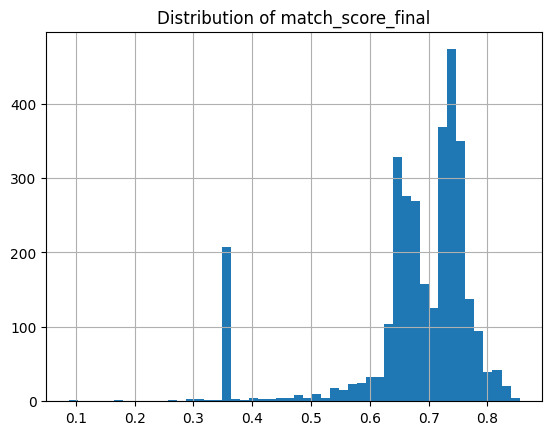

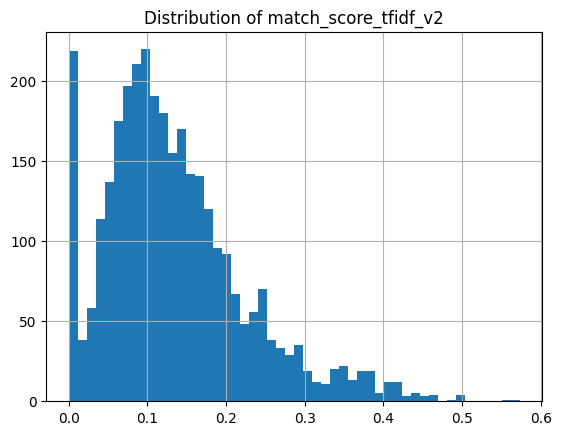

In [8]:
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure()
df["match_score_final"].hist(bins=50)
plt.title("Distribution of match_score_final")
plt.show()

plt.figure()
df["match_score_tfidf_v2"].hist(bins=50)
plt.title("Distribution of match_score_tfidf_v2")
plt.show()


In [9]:
df[df["jobtitle_raw"].str.lower().eq("member")][
    ["jobtitle_raw","jobtitle_norm","soc_code_final","match_type","match_score","mapped_role","job_category","match_score_final"]
].head(20)


,jobtitle_raw,jobtitle_norm,soc_code_final,match_type,match_score,mapped_role,job_category,match_score_final
848,Member,member,25-1122.00,fuzzy,100.0,ambassador,Admin,0.166882


In [10]:
# ----------------------------
# Component correlation analysis
# ----------------------------
# We want each sub-score to capture a DIFFERENT aspect of fit.
# If correlations are very high (>0.8), two components are redundant.
# If correlations are ~0 or negative, they're measuring independent things (ideal).

score_cols = ["match_score_tfidf_v2", "edu_match_score", "exp_match_score", "train_match_score"]
corr = df[score_cols].corr()
print("Component correlation matrix:")
print(corr.round(3))

print("\nKey observations:")
for i, c1 in enumerate(score_cols):
    for c2 in score_cols[i+1:]:
        r = corr.loc[c1, c2]
        if abs(r) > 0.7:
            print(f"  WARNING: {c1} and {c2} are highly correlated (r={r:.3f}) — consider merging or re-weighting")
        elif abs(r) < 0.1:
            print(f"  OK: {c1} and {c2} are nearly independent (r={r:.3f})")

# Variance explained by each component
if "match_score_final" in df.columns:
    print("\nCorrelation of each component with final score:")
    for c in score_cols:
        r = df[[c, "match_score_final"]].corr().iloc[0, 1]
        print(f"  {c}: {r:.3f}")

Component correlation matrix:
                      match_score_tfidf_v2  edu_match_score  exp_match_score  \
match_score_tfidf_v2                 1.000            0.202            0.165   
edu_match_score                      0.202            1.000            0.161   
exp_match_score                      0.165            0.161            1.000   
train_match_score                    0.350            0.321            0.670   

                      train_match_score  
match_score_tfidf_v2              0.350  
edu_match_score                   0.321  
exp_match_score                   0.670  
train_match_score                 1.000  

Key observations:

Correlation of each component with final score:
  match_score_tfidf_v2: 0.539
  edu_match_score: 0.546
  exp_match_score: 0.722
  train_match_score: 0.870


In [11]:
# ----------------------------
# Score calibration & distribution analysis
# ----------------------------
# A well-calibrated score should be broadly distributed across [0, 1].
# If it's clumped (e.g., everything between 0.35-0.50) then it doesn't discriminate well.

print("Score distribution summary:")
print(df["match_score_final"].describe())

# Decile analysis
df["_score_decile"] = pd.qcut(df["match_score_final"], 10, labels=False, duplicates="drop")
decile_stats = df.groupby("_score_decile").agg(
    count=("match_score_final", "count"),
    mean_score=("match_score_final", "mean"),
    min_score=("match_score_final", "min"),
    max_score=("match_score_final", "max"),
).reset_index()
print("\nDecile breakdown:")
print(decile_stats.to_string(index=False))

# Effective range
p5 = df["match_score_final"].quantile(0.05)
p95 = df["match_score_final"].quantile(0.95)
print(f"\n5th-95th percentile range: [{p5:.3f}, {p95:.3f}] (spread = {p95-p5:.3f})")
if p95 - p5 < 0.15:
    print("WARNING: Score has very narrow spread. Consider re-calibrating weights or adding discriminating features.")
else:
    print("OK: Score has reasonable spread for discrimination.")

# Check for mapping confidence (if available)
if "mapping_confidence" in df.columns:
    print("\nMapping confidence distribution:")
    print(df["mapping_confidence"].describe())
    print("\nLow-confidence mappings (< 0.5):", (df["mapping_confidence"] < 0.5).mean())

df.drop(columns=["_score_decile"], inplace=True)

Score distribution summary:
count    3218.000000
mean        0.677214
std         0.110294
min         0.087791
25%         0.652587
50%         0.706160
75%         0.743026
max         0.854518
Name: match_score_final, dtype: float64

Decile breakdown:
 _score_decile  count  mean_score  min_score  max_score
           0.0    322    0.391199   0.087791   0.567421
           1.0    322    0.626007   0.568285   0.645227
           2.0    322    0.652773   0.645249   0.660083
           3.0    321    0.669673   0.660199   0.678640
           4.0    323    0.690919   0.678772   0.706160
           5.0    321    0.720752   0.706316   0.728350
           6.0    321    0.733074   0.728403   0.738175
           7.0    323    0.743232   0.738223   0.748836
           8.0    322    0.756068   0.748949   0.764624
           9.0    321    0.788831   0.764725   0.854518

5th-95th percentile range: [0.354, 0.782] (spread = 0.428)
OK: Score has reasonable spread for discrimination.

Mapping confiden